In [64]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np

In [65]:
#args
location = 'TheGambia'
root = ''
quiet = False
#_______________________

dataset_links = pd.read_csv(os.path.join(root, 'dataset-links.csv'))
country_links = dataset_links[dataset_links.Location == location]
#eventualmente filtrare anche sul quadkey
if not quiet:
    print(f"Found {len(country_links)} links for {location}")

gdfs = []
for _, row in country_links.iterrows():
    df = pd.read_json(row.Url, lines=True)
    df["geometry"] = df["geometry"].apply(shape)
    gdf_down = gpd.GeoDataFrame(df, crs=4326)
    gdfs.append(gdf_down)

gdfs = pd.concat(gdfs)

Found 6 links for TheGambia


In [82]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sampler = MyGridGeoSampler(dataset, size=1080, stride=1080)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

In [83]:
gdfs_32628 = gdfs.to_crs(data_crs)
index_MS_buildings = gdfs_32628.sindex

In [69]:
def rel_bbox_coords(geodf:gpd.GeoDataFrame,
                    ref_coords:tuple,
                    res):
    """
    Returns the relative coordinates of a bbox w.r.t. a reference bbox in the 'geometry' column

    Inputs:
        geodf: dataframe with bboxes
        ref_coords: a tuple in the format (minx, miny, maxx, maxy)
        res: resolution of the image
    Returns:
        a list of tuples with the relative coordinates of the bboxes [(minx, miny, maxx, maxy), ...]
    """
    result = []
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner
    #print('\nref_coords top left: ', ref_minx, ref_maxy )
    for geom in geodf['geometry']:
        building_minx, building_miny, building_maxx, building_maxy = geom.bounds
        #print('\nBefore building_tuple: ', building_minx, building_miny, building_maxx, building_maxy)
        #print('After building_tuple: ', building_minx - ref_minx, ref_maxy - building_miny, building_maxx - ref_minx, ref_maxy - building_maxy)
        #reslut.append((building_minx - ref_minx, building_miny - ref_maxy, building_maxx - ref_minx, building_maxy - ref_maxy))
        rel_bbox_coords = tuple(np.array([building_minx - ref_minx, ref_maxy - building_miny, building_maxx - ref_minx, ref_maxy - building_maxy]) / res)
        result.append(rel_bbox_coords)
    
    return result

In [70]:
def rel_polyg_coord(geodf:gpd.GeoDataFrame,
                    ref_coords:tuple,
                    res):
    """
    Returns the relative coordinates of a polygon w.r.t. a reference bbox

    Inputs:
        geodf: dataframe with polygons in the 'geometry' column
        ref_coords: a tuple in the format (minx, miny, maxx, maxy)
        res: resolution of the image
    Returns:
        a list of lists of tuples with the relative coordinates of the bboxes [[(p1_minx1, p1_miny1), (p1_minx2, p1_miny2), ...], [(p2_minx1, p2_miny1), (p2_minx2, p2_miny2), ...], ...]
    """
    result = []
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner

    for geom in geodf['geometry']:
        x_s, y_s = geom.exterior.coords.xy
        rel_x_s = (np.array(x_s) - ref_minx) / res
        rel_y_s = (ref_maxy - np.array(y_s)) / res
        rel_coords = list(zip(rel_x_s, rel_y_s))
        result.append(rel_coords)
    return result   
       

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (316162.109375, 1489843.75)
dx_high:  (316491.69921875, 1490173.33984375)


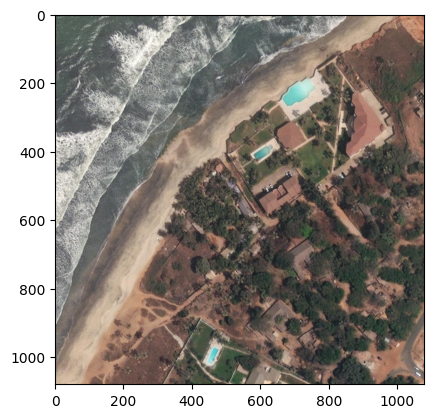

In [84]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

dataset_res = dataset.res

for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)

    if len(hits) > 5:
        sample = unbind_samples(batch)[0]
        img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
        #img= img.permute(1, 2, 0).numpy().astype('uint8')
        #img = img.numpy()
        #img = img.astype('uint8')
        #plt.imshow(img)

        fig, ax = dataset.plot(sample)
        i=0
        plt.savefig('output.png')

        building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res)
        """for tup in building_boxes:
            minx, miny, maxx, maxy = tup
            rect = patches.Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=1, edgecolor='r', facecolor='none')            
            ax.add_patch(rect)
        
        for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
            poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(poly)"""

        break

In [85]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda')

predictor = SamPredictor(sam)

In [86]:
predictor.set_image(img4Sam)

In [87]:
import torch
building_boxes_t = torch.tensor(building_boxes, device=predictor.device)
building_boxes_t

tensor([[1056.7629, 1107.9340, 1109.1298, 1068.5433],
        [ 650.2392, 1105.2010,  693.5493, 1061.9352],
        [ 541.6617, 1137.2571,  659.9724, 1021.5084],
        [ 529.6404, 1043.7408,  568.5181, 1014.0300],
        [ 662.3535,  995.9368,  685.2133,  973.2211],
        [ 436.8821,  768.2303,  466.9585,  738.2292],
        [ 715.7844,  959.8382,  753.6513,  922.7205],
        [ 610.4000,  928.9057,  710.9740,  829.1930],
        [ 675.3052,  764.2427,  776.5841,  656.7963],
        [ 478.2286,  707.5431,  521.1169,  665.2586],
        [ 564.9656,  695.9831,  601.2666,  657.8293],
        [ 529.8812,  581.9987,  575.2277,  530.7469],
        [ 603.6807,  586.7691,  741.5286,  478.9625],
        [ 512.8982,  530.3859,  546.1244,  493.6169],
        [ 470.0991,  466.5201,  501.7015,  434.6872],
        [ 511.5043,  423.8161,  538.4102,  399.0706],
        [ 898.3621, 1030.3574,  935.1195, 1001.7905],
        [ 900.2230,  945.5887,  938.6437,  905.5250],
        [ 841.0387,  445.510

In [88]:
#Given the box coorindates as xyxy return the center of the rectangle
point_coords = torch.tensor([[(sublist[0] + sublist[2])/2, (sublist[1] + sublist[3])/2] for sublist in building_boxes_t], device=predictor.device)
point_coords.shape

torch.Size([21, 2])

In [89]:
point_labels = torch.tensor([1] * point_coords.shape[0], device=predictor.device)
point_labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [90]:
transformed_points = predictor.transform.apply_coords_torch(point_coords, img4Sam.shape[:2]).unsqueeze(1)


In [91]:
transformed_boxes = predictor.transform.apply_boxes_torch(building_boxes_t, img4Sam.shape[:2])
transformed_boxes.shape

torch.Size([21, 4])

In [98]:
masks, _, _ = predictor.predict_torch(
    point_coords=transformed_points,
    point_labels=point_labels[:, None],
    boxes=None,
    multimask_output=False,
)

In [96]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=0.25))


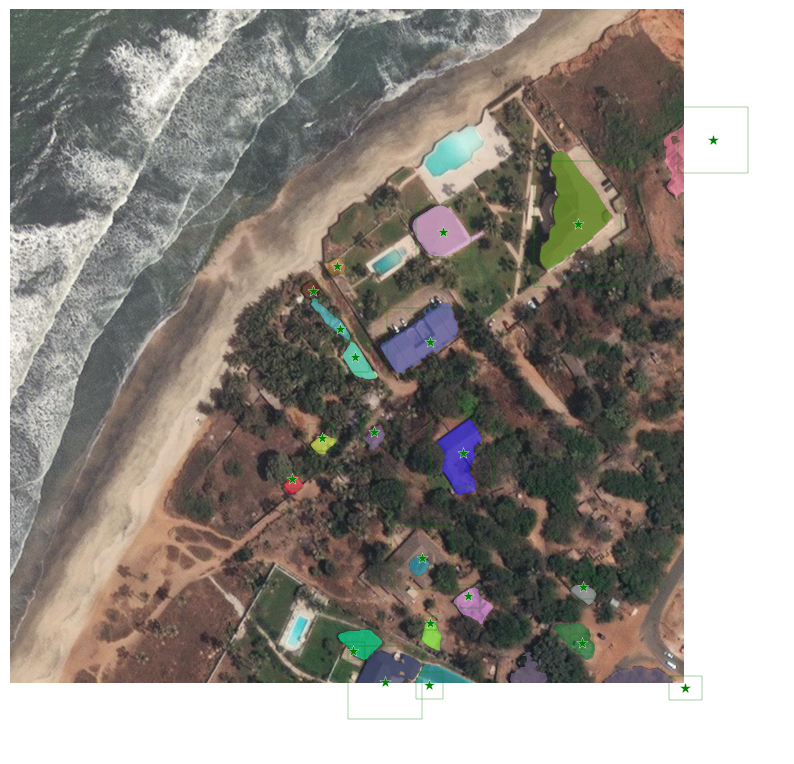

In [99]:
plt.figure(figsize=(10, 10))
plt.imshow(img4Sam)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in building_boxes_t:
    show_box(box.cpu().numpy(), plt.gca())
for point, label in zip(point_coords.cpu(), point_labels.cpu()):
    show_points(coords=point, labels = label, ax = plt.gca())

plt.axis('off')
plt.show()